### 1.Importing packages 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings

warnings.filterwarnings('ignore') # supressing warnings

### 2.UDF's for EDA

In [2]:
# Create Data audit Report for continuous variables
def continuous_var_summary( x ):
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max']) 

In [3]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [4]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    elif ( x.dtypes == 'category'):
        x = x.fillna(x.mode()[0])
    else: 
        x ='improper data type' 
    return x

In [5]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### 3.Loading data

In [6]:
cred_cons = pd.read_excel('CreditConsumptionData.xlsx') 
cust_demo = pd.read_excel('CustomerDemographics.xlsx')
cust_behv = pd.read_excel('CustomerBehaviorData.xlsx')

### Meta Data inspection

In [7]:
cred_cons.info()
# 5000 null values in cc_cons columns.
# These 5000 values will be treated as test data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       20000 non-null  int64  
 1   cc_cons  15000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 312.6 KB


In [8]:
cust_demo.info()
# many columns have missing values
# no of missing values is not large in any of the columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   account_type                  19999 non-null  object 
 2   gender                        19999 non-null  object 
 3   age                           20000 non-null  int64  
 4   Income                        19999 non-null  object 
 5   Emp_Tenure_Years              20000 non-null  float64
 6   Tenure_with_Bank              20000 non-null  int64  
 7   region_code                   19999 non-null  float64
 8   NetBanking_Flag               20000 non-null  int64  
 9   Avg_days_between_transaction  19997 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 1.5+ MB


In [9]:
cust_behv.info()
# many columns have missing values.
# no of missing values is not large in any of the columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     20000 non-null  int64  
 1   cc_cons_apr            20000 non-null  float64
 2   dc_cons_apr            20000 non-null  float64
 3   cc_cons_may            19999 non-null  float64
 4   dc_cons_may            20000 non-null  float64
 5   cc_cons_jun            20000 non-null  float64
 6   dc_cons_jun            19999 non-null  float64
 7   cc_count_apr           19999 non-null  float64
 8   cc_count_may           20000 non-null  int64  
 9   cc_count_jun           20000 non-null  int64  
 10  dc_count_apr           20000 non-null  int64  
 11  dc_count_may           20000 non-null  int64  
 12  dc_count_jun           20000 non-null  int64  
 13  card_lim               20000 non-null  int64  
 14  personal_loan_active   20000 non-null  int64  
 15  ve

### 4.Combining the data

In [10]:
# Combining cust_demo,cust_behv and cred_cons on the basis of 'ID' column.
df = cust_demo.merge(right=cred_cons,on='ID',how='inner').merge(right=cust_behv,on='ID',how='inner')
df.head()

,ID,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,...,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active
0,19427,current,M,63,MEDIUM,30.1,10,628.0,1,5.0,...,5,14,20770.0,44884.90,369000.75,40,96,46088.0,Y,2646.72
1,16150,current,M,36,MEDIUM,14.4,10,656.0,0,12.0,...,4,63,78627.0,91073.84,243182.32,7,12,17953.0,Y,5469.79
2,11749,current,F,28,MEDIUM,4.8,10,314.0,1,13.0,...,6,82,1260.0,96552.00,35467.00,16,42,41121.0,Y,7207.85
3,11635,current,M,32,MEDIUM,9.6,2,614.0,1,19.0,...,2,78,23332.0,18250.00,87204.35,2,10,32003.0,Y,591.34
4,8908,current,M,32,HIGH,12.0,7,750.0,1,18.0,...,3,171,41672.0,83525.75,83992.00,21,12,9626.0,Y,2621.39


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   account_type                  19999 non-null  object 
 2   gender                        19999 non-null  object 
 3   age                           20000 non-null  int64  
 4   Income                        19999 non-null  object 
 5   Emp_Tenure_Years              20000 non-null  float64
 6   Tenure_with_Bank              20000 non-null  int64  
 7   region_code                   19999 non-null  float64
 8   NetBanking_Flag               20000 non-null  int64  
 9   Avg_days_between_transaction  19997 non-null  float64
 10  cc_cons                       15000 non-null  float64
 11  cc_cons_apr                   20000 non-null  float64
 12  dc_cons_apr                   20000 non-null  float64
 13  c

### 5.Dividing the data into categorical and continuous

In [11]:
cont_cols = ['age','Emp_Tenure_Years','Tenure_with_Bank','Avg_days_between_transaction','cc_cons',
            'cc_cons_apr', 'dc_cons_apr','cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun',
             'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr','dc_count_may', 'dc_count_jun',
             'card_lim','personal_loan_active','vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed',
             'investment_1', 'investment_2', 'investment_3', 'investment_4','debit_amount_apr', 'credit_amount_apr', 
             'debit_count_apr','credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may','credit_amount_may', 
             'credit_count_may', 'debit_count_may','max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun',
             'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun','emi_active'] 

categorical_cols = ['account_type','gender','Income','region_code', 'NetBanking_Flag','loan_enq']

In [12]:
continuous_df = df[cont_cols]
categorical_df = df[categorical_cols]

### 6.Exploratory Data Analysis 
(Before Data Cleaning)

In [13]:
# Boxplot for continuous features
def box_plot_fn(x):
    plt.title('boxplot for '+ x.name)
    sns.boxplot(x)
    plt.show()

In [14]:
# Frequency plot for categorical features
def fn_create_freq_plot(x):
    plt.figure(figsize=(7,4))
    plt.title('Frequency plot for ' + x.name )
    x.value_counts().plot(kind='bar',edgecolor='tomato',color='steelblue')
    plt.show()

#### 6.1 Frequency plots for categorical features

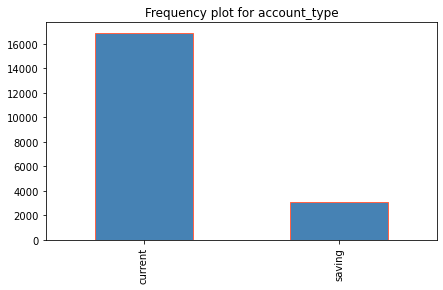

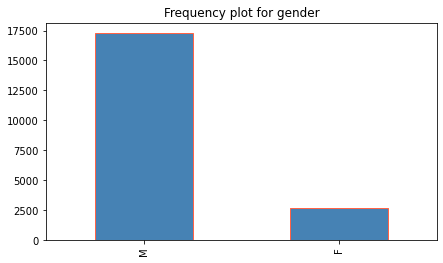

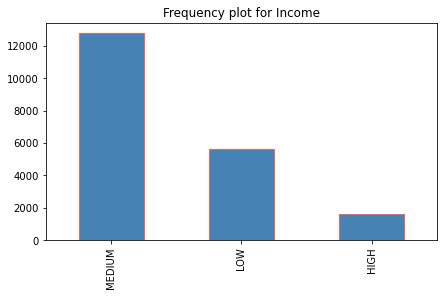

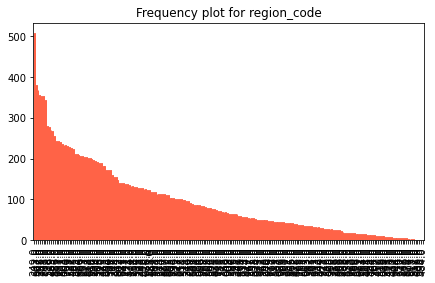

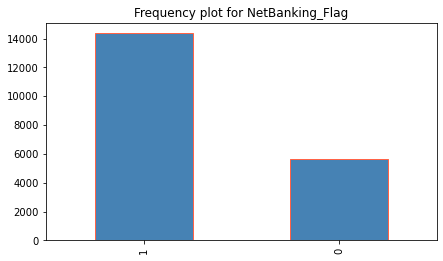

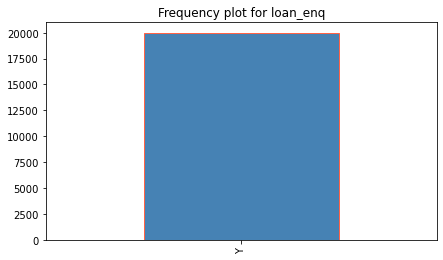

In [66]:
categorical_df.apply(fn_create_freq_plot)
plt.show()

#### 6.2 Boxplot for continuous features

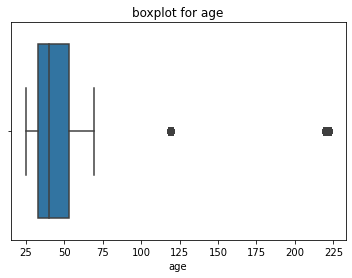

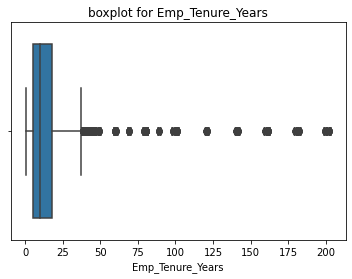

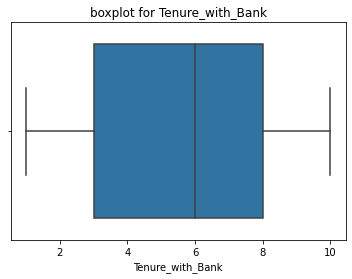

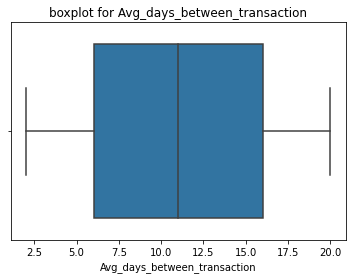

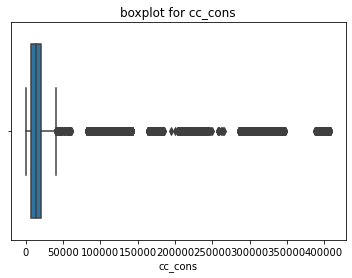

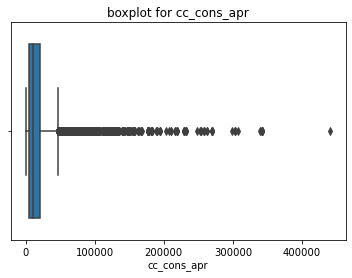

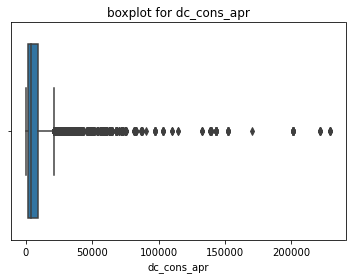

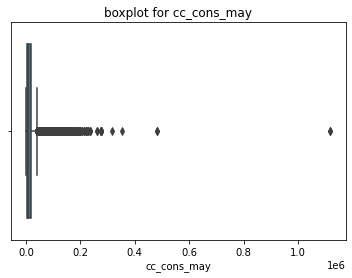

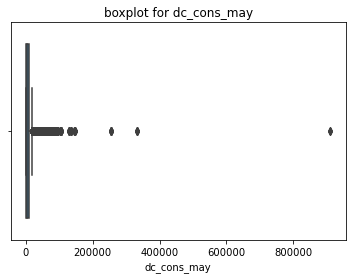

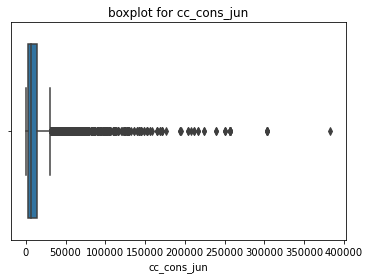

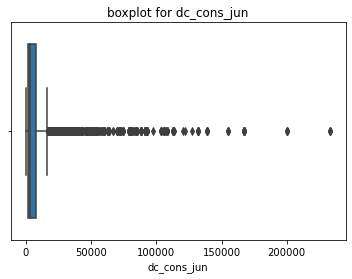

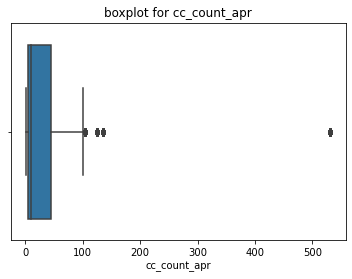

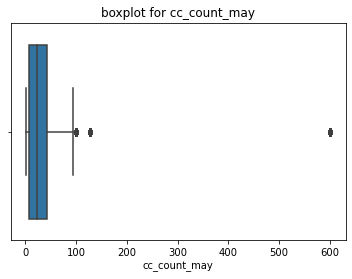

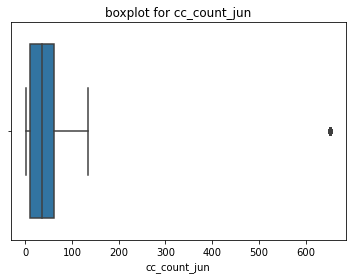

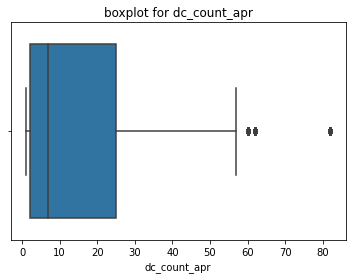

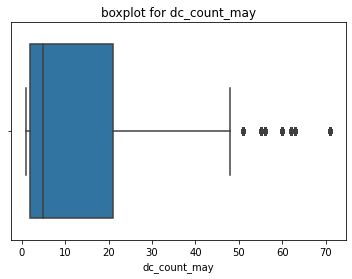

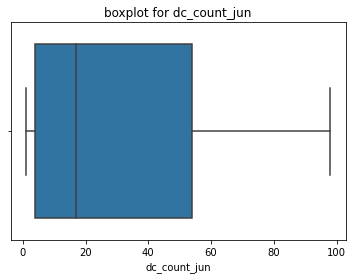

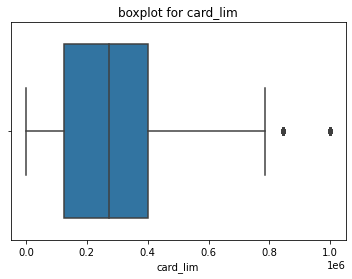

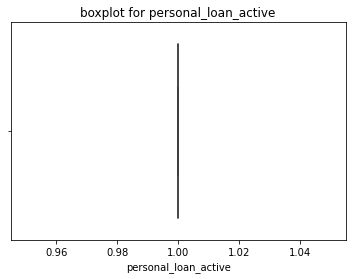

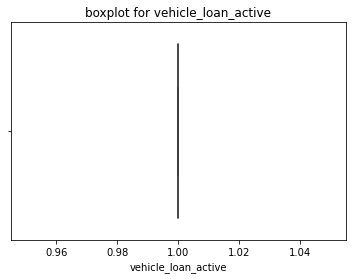

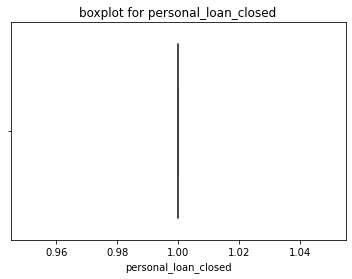

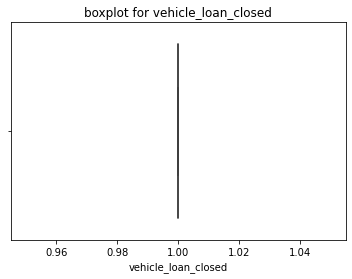

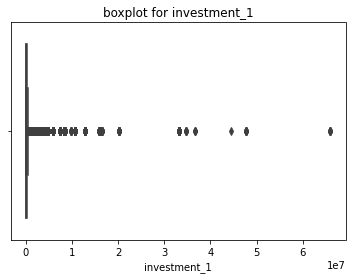

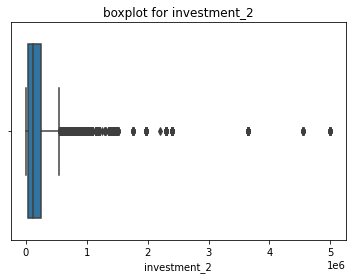

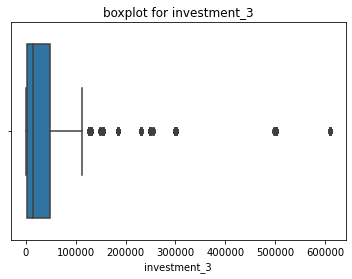

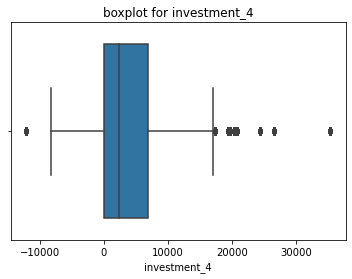

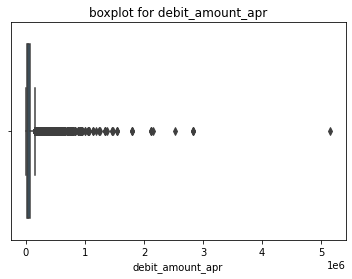

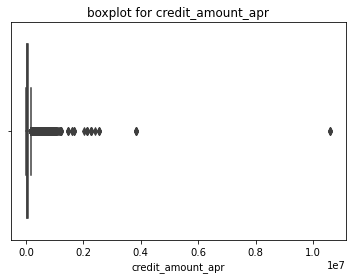

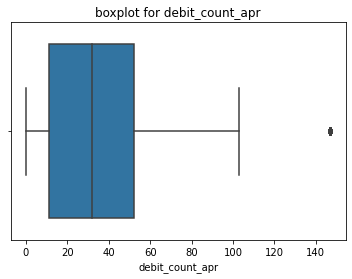

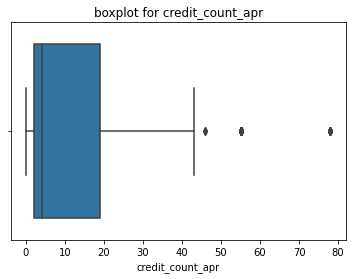

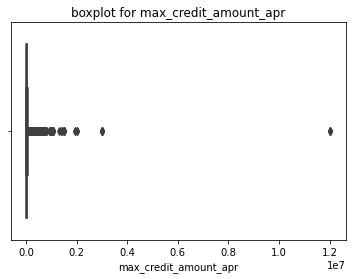

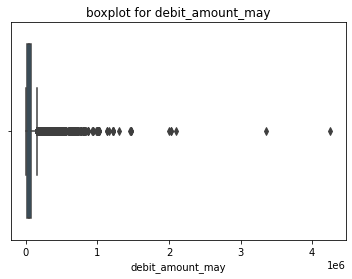

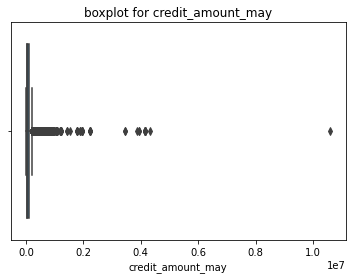

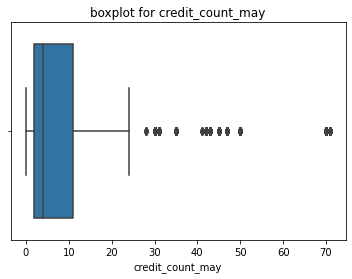

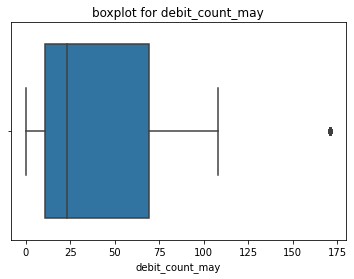

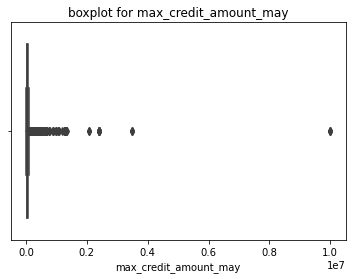

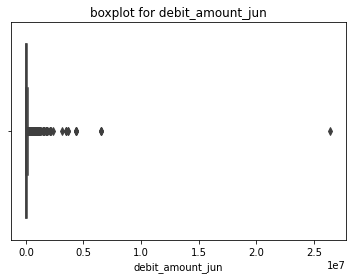

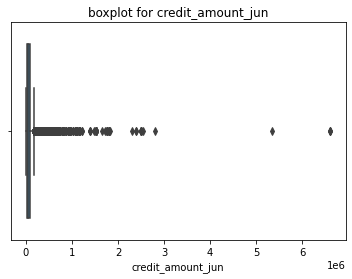

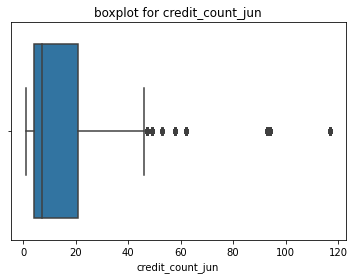

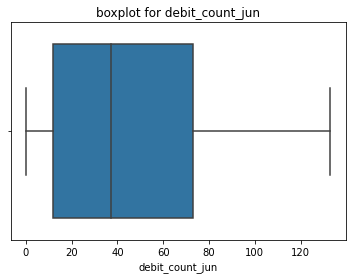

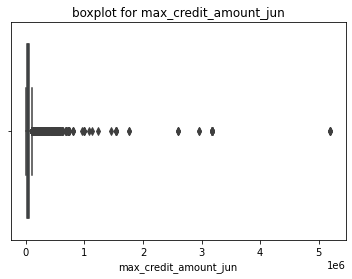

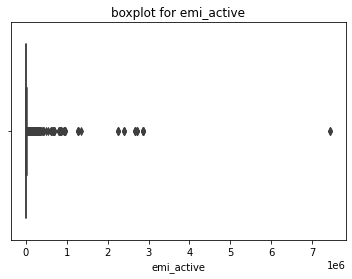

In [67]:
continuous_df.apply(box_plot_fn)
plt.show()

## NOTE:
    # Nearly all continuous features have outliers from the 
    
    # But most of them have extreme outlier 
    
    # clipping them at 1% is okay but clipping at  99% is not going to remove extreme ouliers.
    
    # Most continuous features have extreme outliers from the one end(higher cutoff should be 95%)
    
    # so for some features clipping needs to be done at 1% and 95% and that seems to resolve the outlier problem.

#### 6.3 Summary table for cont variables

In [68]:
cont_summ = continuous_df.apply(continuous_var_summary)
cont_summ
#cont_summ.to_excel('cont_summ_1.xlsx')

,age,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,...,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active
dtype,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,...,float64,int64,int64,float64,float64,float64,int64,int64,float64,float64
cardinality,43,270,10,19,12260,8459,3861,8504,4053,7347,...,8144,31,57,5299,8632,8311,39,66,5833,5940
n_tot,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,...,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
n,20000,20000,20000,19997,15000,20000,20000,19999,20000,20000,...,20000,20000,20000,20000,20000,20000,20000,20000,20000,19999
nmiss,0,0,0,3,5000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
perc_miss,0.0,0.0,0.0,0.015,25.0,0.0,0.0,0.005,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005
sum,953446,304345.0,109921,220862.0,827365948.0,357139818.44,162609068.27,323751105.97,154048543.82,242716120.41,...,1658741376.03,238380,819497,1164159702.76,1562455943.19,1576338552.15,398109,890582,1056996951.42,307961976.6
mean,47.6723,15.21725,5.49605,11.044757,55157.729867,17856.990922,8130.453414,16188.364717,7702.427191,12135.806021,...,82937.068801,11.919,40.97485,58207.985138,78122.79716,78816.927607,19.90545,44.5291,52849.847571,15398.868773
std,30.359771,20.481455,2.870452,5.480552,97670.972252,25158.878234,14572.188829,26510.681596,17892.7318,18790.984789,...,171476.075856,16.85576,40.561202,208591.362703,244898.308732,156987.241764,27.055323,35.080453,134317.525107,120254.075769
var,921.715698,419.489979,8.239496,30.036454,9539618820.721489,632969153.988079,212348687.260089,702816238.690255,320149851.281652,353101109.329598,...,29404044591.082455,284.116645,1645.211078,43510356594.345634,59975181619.710663,24644994076.810459,731.99051,1230.638185,18041197550.945358,14461042739.004244


#### 6.4 Distribution for each continuous feature using Histograms

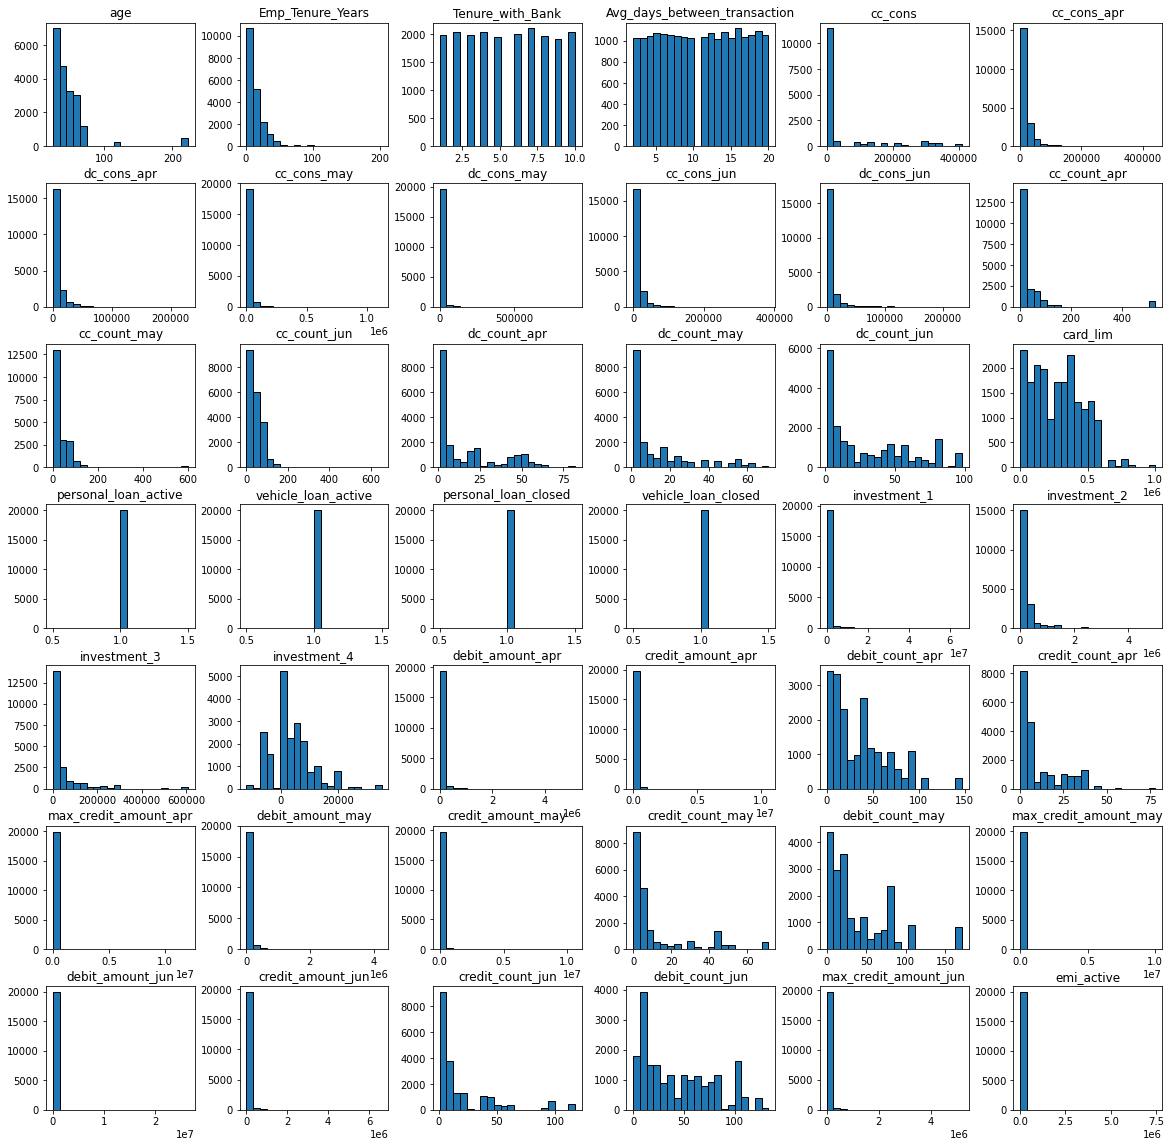

In [69]:
df[cont_cols].hist(bins=20, figsize=(20,20),edgecolor='black',grid=False)
plt.show()

### 7. Data Cleaning or Data preprocessing

In [15]:
# outlier treatment for continuous variables
continuous_df = continuous_df.apply(lambda x:x.clip(lower=x.quantile(0.01),upper=x.quantile(0.95)))

In [16]:
# missing value imputation [Mean value imputation]
continuous_df[continuous_df.columns.difference({'cc_cons'})] =  continuous_df[continuous_df.columns.difference({'cc_cons'})].apply(missing_imputation)

In [17]:
# Summary after treatment
cont_summ2 = continuous_df.apply(continuous_var_summary)
cont_summ2
#cont_summ2.to_excel('cont_summ2.xlsx')

,age,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,...,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active
dtype,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,...,float64,int64,int64,float64,float64,float64,int64,int64,float64,float64
cardinality,33,206,10,20,11395,7957,3640,7990,3801,6908,...,7665,28,55,4999,8122,7807,38,60,5495,5581
n_tot,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,...,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
n,20000,20000,20000,20000,15000,20000,20000,20000,20000,20000,...,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
nmiss,0,0,0,0,5000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,869082,264784.6,109921,220895.13427,797443082.5,316439838.515,136733347.27,279517147.457373,125570272.58,210368531.805,...,1412359203.78,225438,767474,909648706.35,1295937536.49,1323944812.01,387046,880112,855850409.71,150400418.150907
mean,43.4541,13.23923,5.49605,11.044757,53162.872167,15821.991926,6836.667364,13975.857373,6278.513629,10518.42659,...,70617.960189,11.2719,38.3737,45482.435318,64796.876825,66197.240601,19.3523,44.0056,42792.520486,7520.020908
std,12.693658,10.730398,2.870452,5.480141,91565.715934,15781.400636,7406.283512,14372.836989,6688.139665,10530.639211,...,64309.607378,14.978718,33.537702,39240.231271,56382.443887,60010.710914,25.238592,34.023597,37222.958066,9288.961781
var,161.12895,115.141446,8.239496,30.031949,8384280334.475501,249052606.03554,54853035.463289,206578443.113922,44731212.174662,110894362.198029,...,4135725601.088344,224.361988,1124.777487,1539795750.213261,3178979978.715486,3601285424.363684,636.986534,1157.605149,1385548607.17995,86284810.969826


### EDA for categorical features

In [18]:
categorical_df.info()
# 5 features have missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   account_type     19999 non-null  object 
 1   gender           19999 non-null  object 
 2   Income           19999 non-null  object 
 3   region_code      19999 non-null  float64
 4   NetBanking_Flag  20000 non-null  int64  
 5   loan_enq         19998 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.1+ MB


In [19]:
# Changing the data type of categorical col to category
categorical_df = categorical_df.apply(lambda x:x.astype('category'))

In [21]:
cat_summ1 = categorical_df.apply(categorical_var_summary)
cat_summ1
# cat_summ1.to_excel('cat_summ1.xlsx')

#### Missing value imputation for Categorical features

In [22]:
# Mode value imputation is performed
categorical_df = categorical_df.apply(missing_imputation)
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   account_type     20000 non-null  category
 1   gender           20000 non-null  category
 2   Income           20000 non-null  category
 3   region_code      20000 non-null  category
 4   NetBanking_Flag  20000 non-null  category
 5   loan_enq         20000 non-null  category
dtypes: category(6)
memory usage: 303.3 KB


#### Label Encoding for  categorical features

In [23]:
# Label encoding for gender feature.
categorical_df.gender  = categorical_df.gender.map({'M':1,'F':0})

# Label encoding for Income feature.
categorical_df.Income = categorical_df.Income.map({'LOW':1,'MEDIUM':2,'HIGH':3})

# Label encoding for account_type feature.
categorical_df.account_type = categorical_df.account_type.map({'current':0,'saving':1})

# Encoding loan_enq feature.
categorical_df.loan_enq = categorical_df.loan_enq.map({'Y':1,'N':0})

In [24]:
# Region_code in this data has order, arranging them on the basis of the frequency of region codes(beacuse of high cardinality)
# Using count/frequency encoding for the region code feature 

# getting frequency for each region code 
re_cd=categorical_df.region_code.value_counts().to_dict()

# mapping  frequency to region_code  to new column 
categorical_df.loc[:,'region_code_freq'] = categorical_df['region_code'].map(re_cd) 

categorical_df['Region_freq_code'] = pd.cut(categorical_df.region_code_freq,10,labels=range(1,11))

# dropping region_code column 
categorical_df.drop(columns=['region_code','region_code_freq'],inplace=True)

categorical_df.head(2)

,account_type,gender,Income,NetBanking_Flag,loan_enq,Region_freq_code
0,0,1,2,1,1,3
1,0,1,2,0,1,3


In [27]:
cat_summ2 = categorical_df.apply(categorical_var_summary)
cat_summ2  # No missing value present

#cat_summ2.to_excel('cat_summ2.xlsx')

,account_type,gender,Income,NetBanking_Flag,loan_enq,Region_freq_code
N,20000.00,20000.00,20000.00,20000.0,20000.0,20000.00
NMISS,0.00,0.00,0.00,0.0,0.0,0.00
MODE,0.00,1.00,2.00,1.0,1.0,3.00
FREQ,16926.00,17288.00,12775.00,14360.0,20000.0,3730.00
PERCENT,84.63,86.44,63.88,71.8,100.0,18.65


In [28]:
# Converting data type of categorical features back to integer type
categorical_df = categorical_df.apply(lambda x:x.astype('int64'))

In [29]:
# Final datframe creation: combining categorical and continuous data
final_df=pd.concat([continuous_df,categorical_df],axis=1)

In [30]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           20000 non-null  int64  
 1   Emp_Tenure_Years              20000 non-null  float64
 2   Tenure_with_Bank              20000 non-null  int64  
 3   Avg_days_between_transaction  20000 non-null  float64
 4   cc_cons                       15000 non-null  float64
 5   cc_cons_apr                   20000 non-null  float64
 6   dc_cons_apr                   20000 non-null  float64
 7   cc_cons_may                   20000 non-null  float64
 8   dc_cons_may                   20000 non-null  float64
 9   cc_cons_jun                   20000 non-null  float64
 10  dc_cons_jun                   20000 non-null  float64
 11  cc_count_apr                  20000 non-null  float64
 12  cc_count_may                  20000 non-null  int64  
 13  c

In [31]:
# Separating main data from unseen data
# for unseen data cc_cons(target variable) is not present 

main_df= final_df[final_df.cc_cons.notna()] 
unseen_df = final_df[final_df.cc_cons.isna()]

## More EDA

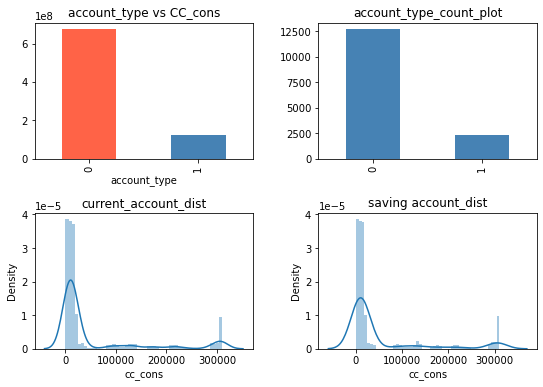

In [86]:
# Impact of account type on credit card consumption
# Current accounts are coded as '0' and Savings type with '1'.
fig = plt.figure(figsize=(9, 6))
grid = plt.GridSpec(2, 2, hspace=0.4, wspace=0.3)
q = fig.add_subplot(grid[0, :1],title = 'account_type vs CC_cons')
w = fig.add_subplot(grid[1, 0],title = 'current_account_dist' )
e = fig.add_subplot(grid[1, 1],title = 'saving account_dist')
f = fig.add_subplot(grid[0,1:],title = 'account_type_count_plot')

main_df.account_type.value_counts().plot(kind='bar',ax = f,color='steelblue')
main_df.groupby(main_df.account_type)['cc_cons'].sum().plot(kind = 'bar',color=('tomato','steelblue'),ax=q)
sns.distplot(main_df[main_df.account_type==0]['cc_cons'],ax =w)
sns.distplot(main_df[main_df.account_type==1]['cc_cons'],ax =e )

plt.show()


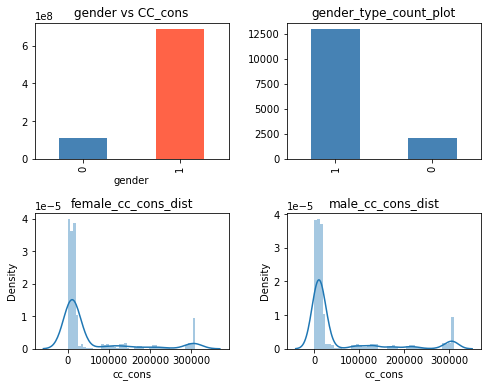

In [87]:
# Impact of gender on credit card consumption
# '0' for female and '1' for male
fig = plt.figure(figsize=(8, 6))
grid = plt.GridSpec(2, 2, hspace=0.4, wspace=0.3)
q = fig.add_subplot(grid[0, :1],title = 'gender vs CC_cons')
w = fig.add_subplot(grid[1, 0],title = 'female_cc_cons_dist' )
e = fig.add_subplot(grid[1, 1],title = 'male_cc_cons_dist')
f = fig.add_subplot(grid[0,1:],title = 'gender_type_count_plot')

main_df.gender.value_counts().plot(kind='bar',ax = f,color='steelblue')
main_df.groupby(main_df.gender)['cc_cons'].sum().plot(kind = 'bar',color=('steelblue','tomato'),ax=q)
sns.distplot(main_df[main_df.gender==0]['cc_cons'],ax =w)
sns.distplot(main_df[main_df.gender==1]['cc_cons'],ax =e )
plt.show()

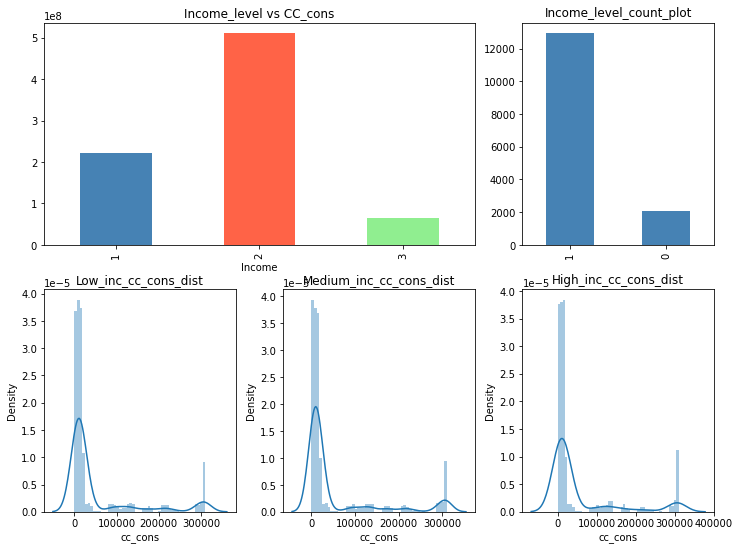

In [88]:
# Impact of Income_level on credit card consumption.
# 'LOW'-1 , 'MEDIUM'- 2, 'HIGH'-3
fig = plt.figure(figsize=(12, 9))
grid = plt.GridSpec(2, 3, hspace=0.2, wspace=0.25)
q = fig.add_subplot(grid[0, :2],title = 'Income_level vs CC_cons')
w = fig.add_subplot(grid[1, :1],title = 'Low_inc_cc_cons_dist' )
e = fig.add_subplot(grid[1, 1:2],title = 'Medium_inc_cc_cons_dist')
f = fig.add_subplot(grid[0,2:],title = 'Income_level_count_plot')
g = fig.add_subplot(grid[1,2:3],title = 'High_inc_cc_cons_dist')

main_df.gender.value_counts().plot(kind='bar',ax = f,color='steelblue')
main_df.groupby(main_df.Income)['cc_cons'].sum().plot(kind = 'bar',color=['steelblue','tomato','lightgreen'],ax=q)
sns.distplot(main_df[main_df.Income==1]['cc_cons'],ax =w)
sns.distplot(main_df[main_df.Income==2]['cc_cons'],ax =e )
sns.distplot(main_df[main_df.Income==3]['cc_cons'],ax =g )
plt.show()

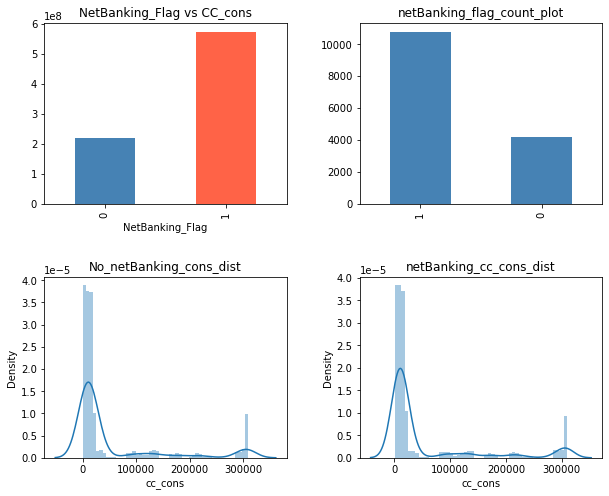

In [89]:
# Impact of Net banking on credit card consumption
# Customer using net banking encoded as 1 and otherwise 0
fig = plt.figure(figsize=(10, 8))
grid = plt.GridSpec(2, 2, hspace=0.4, wspace=0.3)
q = fig.add_subplot(grid[0, :1],title = 'NetBanking_Flag vs CC_cons')
w = fig.add_subplot(grid[1, 0],title = 'No_netBanking_cons_dist' )
e = fig.add_subplot(grid[1, 1],title = 'netBanking_cc_cons_dist')
f = fig.add_subplot(grid[0,1:],title = 'netBanking_flag_count_plot')

main_df.NetBanking_Flag.value_counts().plot(kind='bar',ax = f,color='steelblue')
main_df.groupby(main_df.NetBanking_Flag)['cc_cons'].sum().plot(kind = 'bar',color=('steelblue','tomato'),ax=q)
sns.distplot(main_df[main_df.NetBanking_Flag==0]['cc_cons'],ax =w)
sns.distplot(main_df[main_df.NetBanking_Flag==1]['cc_cons'],ax =e )
plt.show()

In [ ]:
# Converting age to age cat
# main_df['xcv'] = pd.cut(main_df.age,3,labels=[1,2,3])
# main_df.groupby('xcv')['cc_cons'].sum().plot(kind='bar')

In [352]:
# encoding region code freq to give preference to higher freq region codes.
# main_df['cvb' ] = pd.cut(main_df.region_code_freq,5,labels=range(1,6))
# main_df.groupby('cvb')['cc_cons'].sum().plot(kind='bar')

### Assumption checks for Linear regression

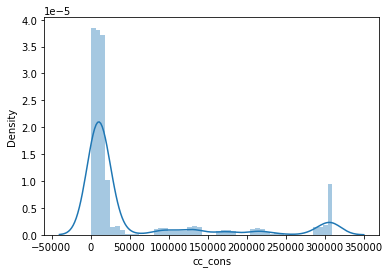

skew of y- 1.9922808525775306


In [32]:
# Checking the distribution of y
sns.distplot(main_df.cc_cons)
plt.show()

# distribution for the y is highly right skewed
# can perform a log transformation  to reduce the skew and make the distrbution Normal

# Checking for the skew
print('skew of y-',(main_df.cc_cons.skew()))

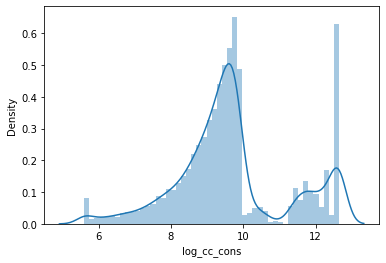

skew of ln(y)- 0.24803345940393753


In [33]:
# Log transformation for target variable 
main_df.loc[:,'log_cc_cons'] = np.log(main_df.loc[:,'cc_cons'])

# checking the distribution of the transformed Y variable
sns.distplot(main_df.log_cc_cons)
plt.show()

# Checking for the skew
print('skew of ln(y)-',main_df.log_cc_cons.skew())

# Transformed variable is still not Normally distributed,but there is significant reduction in amount of skew
# 

In [34]:
# Dropping some statistically insignificant features
# all 5 columns have  0 variance 
main_df.drop(columns=['personal_loan_active', 'personal_loan_closed','vehicle_loan_active', 'vehicle_loan_closed','loan_enq'],inplace=True)

In [93]:
# CoLinearity check 
coor_mat = main_df.corr()
# coor_mat.to_excel('corel_matrix.xlsx')
coor_mat

,age,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,...,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type,gender,Income,NetBanking_Flag,Region_freq_code,log_cc_cons
age,1.000000,0.707838,0.000432,0.005473,-0.004831,-0.004277,-0.002179,-0.004434,0.007492,-0.009998,...,-0.005271,0.003385,-0.002957,0.009134,-0.002869,0.000155,-0.014347,0.009074,-0.004367,-0.008485
Emp_Tenure_Years,0.707838,1.000000,-0.005862,0.006583,-0.008693,-0.001849,-0.002282,-0.009888,0.009426,-0.019433,...,-0.011410,0.007217,0.001511,0.006108,-0.004740,-0.002456,-0.014589,0.002116,-0.011014,-0.014130
Tenure_with_Bank,0.000432,-0.005862,1.000000,0.009384,0.011201,-0.009096,-0.001665,0.010163,0.020937,-0.012462,...,-0.010525,-0.000319,-0.000229,-0.021532,0.013026,0.015768,-0.003874,-0.005822,-0.006821,0.005937
Avg_days_between_transaction,0.005473,0.006583,0.009384,1.000000,-0.004632,0.008941,0.003598,0.012944,0.009457,0.003375,...,-0.004092,0.000680,-0.003839,0.002656,0.000516,0.001055,-0.001349,0.009017,0.005537,-0.010818
cc_cons,-0.004831,-0.008693,0.011201,-0.004632,1.000000,0.002516,0.002008,0.018420,-0.012278,0.005285,...,0.004968,-0.005805,0.008227,0.011534,0.001784,0.002618,0.004901,0.002538,0.007351,0.832182
cc_cons_apr,-0.004277,-0.001849,-0.009096,0.008941,0.002516,1.000000,-0.003016,0.019075,0.003766,-0.007388,...,-0.017153,0.010411,-0.008007,-0.000997,0.017028,0.007348,0.006781,0.003704,0.009056,0.004475
dc_cons_apr,-0.002179,-0.002282,-0.001665,0.003598,0.002008,-0.003016,1.000000,-0.008694,-0.001615,-0.004145,...,-0.016548,-0.007814,-0.006978,-0.004162,0.004976,-0.000875,-0.010300,-0.006360,0.011290,0.008826
cc_cons_may,-0.004434,-0.009888,0.010163,0.012944,0.018420,0.019075,-0.008694,1.000000,-0.005497,-0.016548,...,0.005442,-0.010254,0.008920,0.003493,0.002283,0.010105,0.016651,0.013936,0.014204,0.019645
dc_cons_may,0.007492,0.009426,0.020937,0.009457,-0.012278,0.003766,-0.001615,-0.005497,1.000000,-0.005682,...,-0.014345,0.006942,0.011089,0.005633,0.002599,-0.005456,0.011672,0.004234,0.001061,-0.008674
cc_cons_jun,-0.009998,-0.019433,-0.012462,0.003375,0.005285,-0.007388,-0.004145,-0.016548,-0.005682,1.000000,...,0.001456,0.019244,-0.004466,-0.009697,-0.015130,0.007904,0.004884,-0.003011,0.008765,0.005968


### Hypothesis about data:
    1.Age of the customer is highly corelated to employment tenure of customer.


### Feature Reduction

In [35]:
feature_cols = main_df.columns.difference(['cc_cons','log_cc_cons'])
feature_cols

Index(['Avg_days_between_transaction', 'Emp_Tenure_Years', 'Income',
       'NetBanking_Flag', 'Region_freq_code', 'Tenure_with_Bank',
       'account_type', 'age', 'card_lim', 'cc_cons_apr', 'cc_cons_jun',
       'cc_cons_may', 'cc_count_apr', 'cc_count_jun', 'cc_count_may',
       'credit_amount_apr', 'credit_amount_jun', 'credit_amount_may',
       'credit_count_apr', 'credit_count_jun', 'credit_count_may',
       'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'dc_count_apr',
       'dc_count_jun', 'dc_count_may', 'debit_amount_apr', 'debit_amount_jun',
       'debit_amount_may', 'debit_count_apr', 'debit_count_jun',
       'debit_count_may', 'emi_active', 'gender', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'max_credit_amount_apr',
       'max_credit_amount_jun', 'max_credit_amount_may'],
      dtype='object')

In [36]:
features = main_df[feature_cols]
target = main_df['log_cc_cons']

### Feature Selection

In [37]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import  RFE

In [38]:
# f_regression
features = main_df[feature_cols]
target = main_df['log_cc_cons']

F_values,p_values = f_regression(features,target)
f_reg_output = pd.DataFrame([feature_cols,F_values,p_values]).T
f_reg_output.columns=['Feature','FScore','Pvalue']

# Filter the significant variables at p : 0.1
feature_columns_f_reg=list(f_reg_output.loc[f_reg_output.Pvalue<0.1,'Feature'])
feature_columns_f_reg

['Emp_Tenure_Years', 'cc_cons_may', 'cc_count_may', 'investment_3']

In [42]:
# RFE
DT_reg= DecisionTreeRegressor()
rfe = RFE( estimator=DT_reg, n_features_to_select=20 ).fit( main_df[feature_cols], main_df['log_cc_cons'] )

In [43]:
print(rfe.support_)
print(rfe.ranking_)

RFE_Output = pd.DataFrame([feature_cols, rfe.support_, rfe.ranking_]).T
RFE_Output.columns = ['Features', 'support', 'ranking']

RFE_Output.sort_values( by = 'ranking' )

[False False False False False False False False  True  True  True  True
 False False False  True  True  True False False False  True  True  True
 False False False  True  True  True False False False  True False  True
  True False  True  True  True  True]
[11  2 20 22 19 17 21 16  1  1  1  1  8  9 10  1  1  1 18 14 12  1  1  1
 13  3 15  1  1  1  7  4  6  1 23  1  1  5  1  1  1  1]


,Features,support,ranking
41,max_credit_amount_may,True,1
29,debit_amount_may,True,1
23,dc_cons_may,True,1
22,dc_cons_jun,True,1
21,dc_cons_apr,True,1
40,max_credit_amount_jun,True,1
17,credit_amount_may,True,1
16,credit_amount_jun,True,1
15,credit_amount_apr,True,1
27,debit_amount_apr,True,1


In [45]:
# RFE
feature_columns_rfe = list(feature_cols[rfe.support_])
print(feature_columns_rfe)

['card_lim', 'cc_cons_apr', 'cc_cons_jun', 'cc_cons_may', 'credit_amount_apr', 'credit_amount_jun', 'credit_amount_may', 'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'debit_amount_apr', 'debit_amount_jun', 'debit_amount_may', 'emi_active', 'investment_1', 'investment_2', 'investment_4', 'max_credit_amount_apr', 'max_credit_amount_jun', 'max_credit_amount_may']


In [46]:
# Select k_best
select = SelectKBest(score_func=f_regression,k=15)
z=select.fit_transform(main_df[feature_cols],main_df['log_cc_cons'])

In [47]:
feature_columns_select_kbest=list(feature_cols[select.get_support()])
print(feature_columns_select_kbest)

['Avg_days_between_transaction', 'Emp_Tenure_Years', 'age', 'cc_cons_may', 'cc_count_apr', 'cc_count_may', 'credit_amount_apr', 'credit_amount_jun', 'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'debit_count_apr', 'emi_active', 'investment_3', 'max_credit_amount_jun']


#### For model building taking union of all feature selection methods:
        # f_reg
        # rfe  
        # select_kbest

In [48]:
X_var = list(set(feature_columns_f_reg).union(feature_columns_rfe).union(feature_columns_select_kbest))
print('Features for model building-',X_var)
print('-'*40)
print('No of features- ',len(X_var))

Features for model building- ['age', 'cc_cons_jun', 'cc_cons_may', 'cc_count_may', 'investment_1', 'emi_active', 'investment_2', 'debit_amount_jun', 'dc_cons_jun', 'debit_amount_apr', 'max_credit_amount_apr', 'credit_amount_apr', 'max_credit_amount_may', 'Avg_days_between_transaction', 'investment_3', 'dc_cons_apr', 'credit_amount_jun', 'debit_count_apr', 'cc_count_apr', 'dc_cons_may', 'card_lim', 'cc_cons_apr', 'investment_4', 'Emp_Tenure_Years', 'credit_amount_may', 'debit_amount_may', 'max_credit_amount_jun']
----------------------------------------
No of features-  27


In [130]:
# High VIF of the variable means information in that variable has already been explained by 
# other X variables present in the model
# import the packages for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [147]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = X_var
    vif["VIF"] = [variance_inflation_factor(main_df[X_var].values, i) for i in range(main_df[X_var].shape[1])]    
    return(vif)

In [148]:
calculate_vif(main_df[X_var])

,Features,VIF
0,dc_cons_jun,1.779630
1,cc_cons_jun,1.958586
2,max_credit_amount_jun,2.250036
3,credit_amount_jun,2.152272
4,investment_3,1.419363
5,cc_cons_apr,1.965963
6,age,18.163839
7,debit_amount_jun,2.258011
8,investment_1,1.234515
9,dc_cons_apr,1.819300


### NOTE:
    1.High VIF for age feature,removing age from feature list 

In [150]:
# Removing age from final features list
X_var.remove('age')

### Evaluation metrics
    # Root mean square percentage error(RMSPE) is used for model validation.

In [49]:
# UDF for RMSPE 
a=0.00000000000000001 # Considering the chances of getting y_true to be zero
def rmspe(y_true, y_pred):
    score = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true+a)), axis=0))
    return score*100

### Different types of models used to predict credit card consumption
1. Linear Regression

2. Linear model with regularization(Elastic net model)

3. Decision tree regressor

4. Ensemble learning
        A.Bagging regressor
        B.Random forrest regressor
        C.Ada boost regressor
        D.GBM regressor
        
5. KNN regression model

6. SVM regressor

## Model Buliding Steps
### Train-Test Split

In [40]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [50]:
x_train,x_test,y_train,y_test = train_test_split(main_df[X_var],
                                main_df['log_cc_cons'],test_size=0.3,random_state=123)

### Simple Linear regression model

In [156]:
# Initializing the model
lin_model = linear_model.LinearRegression()
# Fitting the model
LR_model = lin_model.fit(x_train,y_train)

In [157]:
# predicting the outputs
y_train_pred =np.exp(LR_model.predict(x_train))
y_test_pred = np.exp(LR_model.predict(x_test))

In [158]:
# evaluate the model using rmspe
print('RMSPE train:',rmspe(np.exp(y_train), y_train_pred))
print('RMSPE test:',rmspe(np.exp(y_test), y_test_pred))

RMSPE train: 772.6037922516666
RMSPE test: 820.8351178311726


#### NOTE:
    High bias in both train and test

In [129]:
# Model coeff
# pd.DataFrame({'Features':X_var,'Coef':LR_model.coef_}).sort_values(by='Coef',ascending = False)

In [154]:
pd.DataFrame({'actual_y':np.exp(y_train),'pred_y':y_train_pred}).head(50).sort_values(by='actual_y',ascending=False)

,actual_y,pred_y
12607,309852.0,15779.318974
284,304253.0,17213.059043
13576,237012.0,15944.322140
1663,172234.0,14128.450973
2080,134002.0,14961.516304
14331,84146.0,13870.481800
5637,81761.0,16024.129411
9856,20428.0,15760.803384
10435,20023.0,14612.232595
12680,19851.0,14720.506950


### Note
    # can use different regulariztion techniques with cross-validation to improve the model.
    

### Linear model with L1 (LASSO) regularization

In [159]:
# Hyper parameter tuning
model_para = {'alpha':[1000,10000,100000]}

In [160]:
lasso = GridSearchCV(estimator=linear_model.Lasso(),
                                 param_grid=model_para,
                                 n_jobs=-1,
                                 verbose=True,
                                 scoring='neg_mean_squared_error',
                                 cv=10 ).fit(x_train,y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


In [161]:
# getting best value for alpha
lasso.best_params_

{'alpha': 10000}

In [162]:
# fitting the model
lasso_model = lasso.best_estimator_

# predicting the outputs
y_train_pred =np.exp(lasso_model.predict(x_train))
y_test_pred = np.exp(lasso_model.predict(x_test))

# evaluate the model using rmspe
print('RMSPE train:',rmspe(np.exp(y_train), y_train_pred))
print('RMSPE test:',rmspe(np.exp(y_test), y_test_pred))


RMSPE train: 773.9832423558029
RMSPE test: 812.570630652526


#### NOTE:
    High bias in both train and test

### Linear model with L2 (Ridge) regularization

In [163]:
# Hyper parameter tuning
model_para = {'alpha':[100000,1000000,10000000]}

In [164]:
ridge = GridSearchCV(estimator=linear_model.Ridge(),
                                 param_grid=model_para,
                                 n_jobs=-1,
                                 verbose=True,
                                 scoring='neg_mean_squared_error',
                                 cv=10 ).fit(x_train,y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


In [165]:
# getting best value for alpha
ridge.best_params_

{'alpha': 10000000}

In [166]:
# fitting the model
ridge_model = ridge.best_estimator_

# predicting the outputs
y_train_pred =np.exp(ridge_model.predict(x_train))
y_test_pred = np.exp(ridge_model.predict(x_test))

# evaluate the model using rmspe
print('RMSPE train:',rmspe(np.exp(y_train), y_train_pred))
print('RMSPE test:',rmspe(np.exp(y_test), y_test_pred))


RMSPE train: 773.5911377632092
RMSPE test: 819.0653317272526


#### NOTE:
    High bias in both train and test

### Linear model with L1+L2 (Elastic Net) regularization

In [167]:
# Hyper parameter tuning
model_para = {'alpha':[10000,100000,1000000]}

In [168]:
Elastic_net = GridSearchCV(estimator=linear_model.ElasticNet(),
                                 param_grid=model_para,
                                 n_jobs=-1,
                                 verbose=True,
                                 scoring='neg_mean_squared_error',
                                 cv=10 ).fit(x_train,y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


In [169]:
# getting best value for alpha
Elastic_net.best_params_

{'alpha': 100000}

In [170]:
# fitting the model
Elastic_net_model = Elastic_net.best_estimator_

# predicting the outputs
y_train_pred =np.exp(Elastic_net_model.predict(x_train))
y_test_pred = np.exp(Elastic_net_model.predict(x_test))

# evaluate the model using rmspe
print('RMSPE train:',rmspe(np.exp(y_train), y_train_pred))
print('RMSPE test:',rmspe(np.exp(y_test), y_test_pred))


RMSPE train: 773.9832423558029
RMSPE test: 812.570630652526


#### NOTE:
    High bias in both train and test

## ML models
### 1.Decision tree regressor

In [41]:
from sklearn.tree import DecisionTreeRegressor

In [173]:
# Hyper parameter tuning
tree_model_param = {'max_depth':range(1,8)}

In [174]:
DT_reg = GridSearchCV(estimator=DecisionTreeRegressor(random_state=123),
                     param_grid=tree_model_param,
                     cv=10,n_jobs=-1,
                     scoring='neg_mean_squared_error',
                      verbose=True).fit(x_train,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


In [175]:
DT_reg.best_estimator_

DecisionTreeRegressor(max_depth=1, random_state=123)

In [176]:
# fitting the model using tuned max depth
DT_model = DT_reg.best_estimator_
# predicting the values
y_train_pred = np.exp(DT_model.predict(x_train))
y_test_pred = np.exp(DT_model.predict(x_test))

In [177]:
# evaluate the model using rmspe
print('RMSPE train:',rmspe(np.exp(y_train), y_train_pred))
print('RMSPE test:',rmspe(np.exp(y_test), y_test_pred))

RMSPE train: 774.2566839077339
RMSPE test: 807.6073770711746


#### NOTE:
    High bias in both train and test

## ENSEMBLE Methods


In [178]:
# importing required packages
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor,RandomForestRegressor,GradientBoostingRegressor

### 1.Bagging Reg

In [179]:
# Hyper parameter tuning
bagg_param ={'n_estimators':range(400,701,50)}

In [180]:
bagg_reg = GridSearchCV(estimator=BaggingRegressor(oob_score=True,max_samples=0.8,random_state=123),
                        param_grid=bagg_param,n_jobs=-1,
                         cv=10,verbose=True,scoring='neg_mean_squared_error').fit(x_train,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


In [181]:
bagg_reg.best_params_

{'n_estimators': 700}

In [184]:
bagg_model = bagg_reg.best_estimator_

In [185]:
y_train_pred = np.exp(bagg_model.predict(x_train))
y_test_pred = np.exp(bagg_model.predict(x_test))

# evaluate the model using rmspe
print('RMSPE train:',rmspe(np.exp(y_train), y_train_pred))
print('RMSPE test:',rmspe(np.exp(y_test), y_test_pred))

RMSPE train: 102.18944967783297
RMSPE test: 838.2174453232939


#### NOTE:
    Very High bias in test as compared to train ,model is overfitting

### 2.Random forest regressor

In [186]:
rf_param = {'n_estimators':range(700,900,50),
            'max_features':[12,13,14,15]}

In [187]:
random_forrest_model = GridSearchCV(RandomForestRegressor(random_state=123,oob_score=True,max_samples=0.8),
                                   param_grid=rf_param,cv=10,
                                   n_jobs=-1,verbose=True,
                                   scoring='neg_mean_squared_error').fit(x_train,y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


In [188]:
random_forrest_model.best_params_

{'max_features': 15, 'n_estimators': 800}

In [189]:
rf_model = random_forrest_model.best_estimator_

In [190]:
y_train_pred = np.exp(rf_model.predict(x_train))
y_test_pred = np.exp(rf_model.predict(x_test))

# evaluate the model using rmspe
print('RMSPE train:',rmspe(np.exp(y_train), y_train_pred))
print('RMSPE test:',rmspe(np.exp(y_test), y_test_pred))

RMSPE train: 102.30988829955132
RMSPE test: 843.2969025831571


#### NOTE:
    Very High bias in test as compared to train ,model is overfitting

### 3.Ada Boost

In [210]:
ada_boost_param = {'n_estimators':range(50,101,25),
                  'learning_rate':[0.000001,0.00001,0.0001,0.001]}

In [211]:
ada_reg = GridSearchCV(estimator = AdaBoostRegressor(random_state=123),
                      param_grid = ada_boost_param,
                      cv = 10,n_jobs = -1,verbose = True,
                      scoring = 'neg_mean_squared_error').fit(x_train,y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [212]:
ada_reg.best_params_

{'learning_rate': 1e-06, 'n_estimators': 50}

In [213]:
ada_bo_model = ada_reg.best_estimator_

In [214]:
y_train_pred = np.exp(ada_bo_model.predict(x_train))
y_test_pred = np.exp(ada_bo_model.predict(x_test))

# evaluate the model using rmspe
print('RMSPE train:',rmspe(np.exp(y_train), y_train_pred))
print('RMSPE test:',rmspe(np.exp(y_test), y_test_pred))

RMSPE train: 771.1257892614386
RMSPE test: 814.6996434826008


#### NOTE:
    High bias in both train and test

### GBM regressor

In [202]:
gbm_param = {'n_estimators':[35,50,100],
                  'learning_rate':[0.0001,0.001,0.01],
                        'max_features':[18,19,20,21]}

In [203]:
gbm_reg = GridSearchCV(estimator = GradientBoostingRegressor(random_state=123),
                      param_grid = gbm_param,
                      cv = 10,n_jobs = -1,verbose = True,
                      scoring = 'neg_mean_squared_error').fit(x_train,y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


In [204]:
gbm_reg.best_params_

{'learning_rate': 0.001, 'max_features': 19, 'n_estimators': 50}

In [207]:
gbm_model = gbm_reg.best_estimator_

In [208]:
y_train_pred = np.exp(gbm_model.predict(x_train))
y_test_pred = np.exp(gbm_model.predict(x_test))

# evaluate the model using rmspe
print('RMSPE train:',rmspe(np.exp(y_train), y_train_pred))
print('RMSPE test:',rmspe(np.exp(y_test), y_test_pred))

RMSPE train: 773.1031863879089
RMSPE test: 812.3289357712949


#### NOTE:
    High bias in both train and test

### KNN

In [51]:
# preprocessing the data for standardization
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_fit = sc.fit( main_df[X_var] ) 
X_scaled =pd.DataFrame( X_fit.transform( main_df[X_var]))


# X_scaled = pd.DataFrame(sc.fit_transform(X_final))
# X_scaled.head()

X_scaled.columns = X_var

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    main_df['log_cc_cons'], 
                                                    test_size = 0.3, 
                                                    random_state = 123)

In [217]:
# import the packages
from sklearn.neighbors import KNeighborsRegressor

In [218]:
#set the tuning parameters (k) for grid search
tuned_parameters = {'n_neighbors': range( 13,97, 2)}     

# build the KNN model
knn_clf = GridSearchCV( KNeighborsRegressor(),
                   tuned_parameters,
                   cv = 15,
                   scoring = 'neg_mean_squared_error',
                   verbose = True).fit(X_train, y_train)

Fitting 15 folds for each of 42 candidates, totalling 630 fits


In [219]:
knn_clf.best_params_

{'n_neighbors': 95}

In [220]:
knn_model = knn_clf.best_estimator_

In [228]:
y_train_pred = np.exp(knn_model.predict(X_train))
y_test_pred = np.exp(knn_model.predict(X_test))

# evaluate the model using rmspe
print('RMSPE train:',rmspe(np.exp(y_train), y_train_pred))
print('RMSPE test:',rmspe(np.exp(y_test), y_test_pred))

RMSPE train: 760.8768591631277
RMSPE test: 816.3354849751262


#### NOTE:
    High bias in both train and test

### SVM

In [53]:
from sklearn.svm import SVR

In [60]:
# initialize the model
m_SVR = SVR( gamma = 'auto' )

# tuning parameters
params = {'C': np.arange(1,11), 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

# grid search and cv
SVR_model = GridSearchCV( estimator = m_SVR, 
                         param_grid = params, 
                         cv = 5, 
                         n_jobs = -1, 
                         verbose = True,
                         scoring = 'neg_mean_squared_error').fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [61]:
SVR_model.best_params_

{'C': 8, 'kernel': 'linear'}

In [62]:
SVR_model_final = SVR_model.best_estimator_

In [63]:
y_train_pred = np.exp(SVR_model_final.predict(X_train))
y_test_pred = np.exp(SVR_model_final.predict(X_test))

# evaluate the model using rmspe
print('RMSPE train:',rmspe(np.exp(y_train), y_train_pred))
print('RMSPE test:',rmspe(np.exp(y_test), y_test_pred))

RMSPE train: 666.3806969099574
RMSPE test: 699.5150668353756


#### NOTE:
     # SVM regressor gives good performance on both train and test.
     # For unseen data, SVM regressor is used.

## Decile Analysis

#### 1.For Train data

In [72]:
train = pd.DataFrame({'y_actual':np.exp(y_train),'y_predicted':y_train_pred})
train['decile']= pd.cut(train.y_predicted,10 ,labels=False)
train.head(2)

,y_actual,y_predicted,decile
5353,5463.0,12586.473953,2
12786,638.0,13287.698876,4


In [73]:
decile_analysis_train = train.groupby('decile')['y_actual','y_predicted'].mean().sort_index(ascending=False).reset_index()
#decile_analysis_train.to_csv('decile_train.csv')
decile_analysis_train

,decile,y_actual,y_predicted
0,9,11175.500000,15703.367600
1,8,67417.100000,15138.180851
2,7,56854.432690,14699.589059
3,6,56656.612385,14261.490394
4,5,56462.228940,13814.373604
5,4,54176.447149,13383.577637
6,3,50158.576369,12956.809112
7,2,45785.037421,12521.977012
8,1,55618.435644,12077.864069
9,0,64379.000000,11646.597130


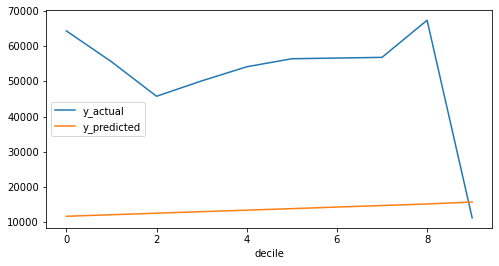

In [66]:
decile_analysis_train.plot(kind='line',x='decile',figsize=(8,4))
plt.show()

#### 2.For test data

In [74]:
test = pd.DataFrame({'y_actual':np.exp(y_test),'y_predicted':y_test_pred})
test['decile']= pd.cut(test.y_predicted,10 ,labels=False)
test.head(2)

,y_actual,y_predicted,decile
7069,4073.0,12135.445333,1
7645,1577.0,12550.136754,2


In [75]:
decile_analysis_test = test.groupby('decile')['y_actual','y_predicted'].mean().sort_index(ascending=False).reset_index()
#decile_analysis_test.to_csv('decile_test.csv')
decile_analysis_test

,decile,y_actual,y_predicted
0,9,21064.000000,15075.783320
1,8,40184.499808,14747.837878
2,7,53937.333229,14365.124595
3,6,50784.985083,13984.431197
4,5,57068.784125,13604.654872
5,4,49284.541460,13236.232772
6,3,51556.984066,12869.288790
7,2,63572.037028,12484.957472
8,1,68680.510312,12125.098745
9,0,33948.434783,11742.229135


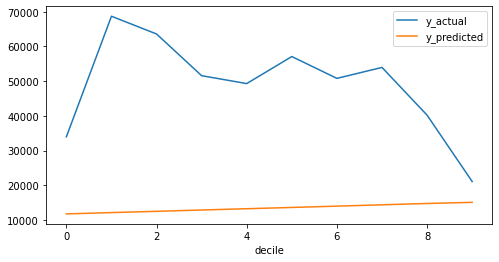

In [69]:
decile_analysis_test.plot(kind='line',x='decile',figsize=(8,4))
plt.show()

In [76]:
# Scaling the unseen_df for prediction using SVR
unseen_df_scaled = pd.DataFrame(X_fit.transform(unseen_df[X_var]))
unseen_df_scaled.columns = X_var

# predicting for unseen using SVR data
unseen_df.cc_cons = np.exp(SVR_model_final.predict(unseen_df_scaled[X_var]))
unseen_df.head()['cc_cons']

0    13342.231737
1    14136.306672
2    12103.272499
3    13684.696014
4    12284.318099
Name: cc_cons, dtype: float64

In [77]:
unseen_df.head()

,age,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,...,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type,gender,Income,NetBanking_Flag,loan_enq,Region_freq_code
0,63,30.1,10,5.0,13342.231737,7998.48,2289.00,9553.00,2879.58,6881.81,...,40,96,46088.0,2646.72,0,1,2,1,1,3
1,36,14.4,10,12.0,14136.306672,16479.64,415.00,7386.49,6763.00,12032.60,...,7,12,17953.0,5469.79,0,1,2,0,1,3
2,28,4.8,10,13.0,12103.272499,29272.03,27835.00,4170.53,25584.00,531.43,...,16,42,41121.0,7207.85,0,0,2,1,1,4
3,32,9.6,2,19.0,13684.696014,9662.31,5306.39,5261.00,11934.79,7996.00,...,2,10,32003.0,591.34,0,1,2,1,1,4
4,32,12.0,7,18.0,12284.318099,13239.86,7063.00,19193.13,22304.86,5984.75,...,21,12,9626.0,2621.39,0,1,3,1,1,2


In [78]:
#unseen_df.to_csv("unseen_data_predictions.csv")